<a href="https://colab.research.google.com/github/the-datastrategist/colab-notebooks/blob/main/tds_session_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# eCommerce Visit Segmentation

##### IN PROGRESS

<br>

#### Overview
In this analysis, we **segment the visits to an e-commerce store based on the visitors' behavior**. The goal is to understand types of trips users take to the store. We use k-means clustering to achieve this.

<br>

#### Data
We used a year of data taken from the [Google Merchandise Store](https://shop.googlemerchandisestore.com/). Google made this data available as part of their [Google Analytics demo account](https://support.google.com/analytics/answer/6367342?hl=en#zippy=%2Cin-this-article). User IDs and PII data have been removed from the dataset, which limits the user-level insights we can generate from this dataset.

<br>

#### Methodology
We apply k-means clustering by `visitId` to create the segments. We have created features that relate to these concepts:

- __Session Behavior.__ Engagement metrics for a given session. This shows _how_ users purchase.

- __% Pageviews by Category.__ A distribution of pageviews by category. This shows _what_ users purchase.

<br>

#### General Notes

- The notes that have been added to this notebook are intended for data scientists. I have communicated most information in (fairly) layman form so that business stakeholders can follow along.

- You can replicate this work on your own using Google BigQuery and OpenAI (for the ChatGPT component of the analysis).

- If you have any questions or feedback, please contact gordon@thedatastrategist.com.

<br>

#### Resources
- [Google Merch Store | cluster_summary](https://docs.google.com/spreadsheets/d/1ospRgLwwi134WbIFZ4UmmWWgpWHfvMxVex_1oklBjSM)
- [Google Merch Store | tds_session_clustering | Feature Dictionary](https://docs.google.com/spreadsheets/d/1BwZ3dBRBLMWlB4WJy0FC-rsrJI--aoB78PRjthgWb4E)
- [Google Merchandise Store](https://shop.googlemerchandisestore.com/)
- [About: Google Merchandise Store Demo Account](https://support.google.com/analytics/answer/6367342?hl=en#zippy=%2Cin-this-article)

## Project Initialization

In [ ]:
# Provide your credentials to the runtime
from google.colab import auth
from google.colab import userdata
auth.authenticate_user()

In [ ]:
# Import libraries
import pandas as pd
from google.cloud import bigquery
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm

### Import data from BigQuery

This query calculates many visit-level features (or metrics) from the dataset, `bigquery-public-data.google_analytics_sample.ga_sessions_`. We use Jinja2 to make certain portions of the code dynamic.

<br>

#### Data granularity

The features have been aggregated from the `visit`, `visit-hit`, and `visit-hit-product` levels and output at the `visit` level. We have added each granularity to a separate CTE to prevent row duplication.



In [ ]:
import pandas as pd
from google.cloud import bigquery
from jinja2 import Template

# Specify query parameters
date_from = '20170101'
date_to = '20170201'
paths_level2 = [
    'accessories',
    'apparel',
    'bag',
    'bags',
    'drinkware',
    'electronic',
    'frequently-asked-questions',
    'gift+cards',
    'lifestyle',
    'nest',
    'office',
    'quickview',
    'return-policy',
    'shipping-information',
    'shop+by+brand',
    'terms-of-use',
    'wearables',
]


# Initialized the BigQuery client
client = bigquery.Client(project=userdata.get('GOOGLE_PROJECT_ID'))

# Specify Jinja SQL template
sql_template = """

with

session_totals as (
  -- Get key IDs and session totals
  select
    date                as date_id,
    visitId             as visit_id,
    visitStartTime      as visit_start_time,
    visitNumber         as visit_number,
    totals.visits,
    totals.hits,
    totals.pageviews,
    coalesce(totals.bounces, 0)             as bounces,
    coalesce(totals.transactions, 0)        as transactions,
    coalesce(totals.transactionRevenue, 0)  as transaction_revenue,
    coalesce(totals.newVisits, 0)           as new_visits,
  from `bigquery-public-data.google_analytics_sample.ga_sessions_*`
  where _table_suffix between '{{ date_from }}' and '{{ date_to }}'
  ),

session_hits as (
  -- Get hit (or event) level metrics and agg to visit_id
  select
    visitId               as visit_id,
    max(hit.time)         as time_on_site_msec,
    max(hit.time) / 1000  as time_on_site_sec,
    min(hit.hour)         as time_of_day_hour,
    min(hit.minute)       as time_of_day_min,
    sum(if(hit.isInteraction is True, 1, 0))            as interactions,
    sum(if(hit.page.searchKeyword is not null, 1, 0))   as searches,

    -- Unique page-level counts
    count(distinct(hit.page.pagePathLevel1)) as unique_pages_level1,
    count(distinct(hit.page.pagePathLevel2)) as unique_pages_level2,
    count(distinct(hit.page.pagePathLevel3)) as unique_pages_level3,
    count(distinct(hit.page.pagePathLevel4)) as unique_pages_level4,

    -- Pageviews by page-path
    -- TO DO: Add jinja for other paths
    {% for path in paths_level2 %}
    sum(if(hit.page.pagePathLevel2 like '%{{ path }}%', 1, 0))
    as pageviews_{{ path.replace('+', '_').replace('-', '_') }},
    {% endfor %}
  from `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
  unnest(hits) hit
  where _table_suffix between '{{ date_from }}' and '{{ date_to }}'
  group by 1
),

session_hit_products as (
  -- Get product-view level metrics and aggregate to visit_id
  -- This includes all products visitors view, regardless of engagement
  select
    visitId as visit_id,
    count(distinct(products.productSKU))            as products_viewed,
    count(distinct(products.v2ProductCategory))     as categories_viewed,
    round(avg(products.productPrice) / 1000000, 2)  as avg_product_price_viewed,
    sum(if(isImpression is True, 1, 0))             as product_impressions,
    sum(if(isClick is True, 1, 0))                  as product_clicks,

  from `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
  unnest(hits) as hit,
  unnest(hit.product) as products
  where _table_suffix between '{{ date_from }}' and '{{ date_to }}'
  group by 1
  )

select
    t.*,
    h.* except(visit_id),
    p.* except(visit_id),

    -- ADDITIONAL METRICS
    -- The metrics below were added after the initial clustering
    -- Adding per pageview metrics to create more orthogonal features
    safe_divide(time_on_site_sec, pageviews)    as time_on_site_sec_per_pageview,
    safe_divide(hits, pageviews)                as hits_per_pageview,
    safe_divide(searches, pageviews)            as searches_per_pageview,
    safe_divide(unique_pages_level1, pageviews) as unqiue_pages_per_pageview,
    safe_divide(products_viewed, pageviews)     as products_viewed_per_pageview,
    safe_divide(product_impressions, pageviews) as product_impressions_per_pageview,
    safe_divide(product_clicks, pageviews)      as product_clicks_per_pageview,

    {% for path in paths_level2 %}
    safe_divide(pageviews_{{ path.replace('+', '_').replace('-', '_') }}, pageviews)
    as pct_pageviews_{{ path.replace('+', '_').replace('-', '_') }},
    {% endfor %}

from session_totals t
join session_hits h using(visit_id)
join session_hit_products p using(visit_id)

"""

# Creating a Jinja2 template from the SQL template string
template = Template(sql_template)

# Rendering the template with actual values
sql_query = template.render(
    date_from=date_from,
    date_to=date_to,
    paths_level2=paths_level2
    )

# Run query and load to a dataframe
df = client.query(sql_query).to_dataframe()


In [ ]:
df = df.fillna(0)
df.head()

,date_id,visit_id,visit_start_time,visit_number,visits,hits,pageviews,bounces,transactions,transaction_revenue,...,pct_pageviews_gift_cards,pct_pageviews_lifestyle,pct_pageviews_nest,pct_pageviews_office,pct_pageviews_quickview,pct_pageviews_return_policy,pct_pageviews_shipping_information,pct_pageviews_shop_by_brand,pct_pageviews_terms_of_use,pct_pageviews_wearables
0,20170129,1485760224,1485760224,2,1,1,1,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,20170129,1485760224,1485760224,1,1,20,18,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,20170129,1485749665,1485749665,1,1,1,1,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,20170129,1485758550,1485758550,2,1,1,1,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,20170129,1485715754,1485715754,4,1,1,1,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# df.columns

## Select features

In [ ]:
# Get full list of features
# list(df)

In [ ]:
ID_SET = [
    'date_id',
    'visit_id',
    'visit_start_time',
    'visit_number',
]

FEATURE_SET = [
    'visit_number',
    'visits',
    'hits',
    'pageviews',
    'bounces',
    'transactions', # excluding revenue metrics
    'transaction_revenue', # excluding revenue metrics
    'new_visits', # excluding historical visits
    'time_on_site_msec', # redundant with time_on_site_sec
    'time_on_site_sec',
    'time_of_day_hour', # excluding time of day measures
    'time_of_day_min', # excluding time of day measures
    'interactions',
    'searches',
    'unique_pages_level1',
    'unique_pages_level2',
    'unique_pages_level3',
    'unique_pages_level4',
    'products_viewed',
    'categories_viewed',
    'avg_product_price_viewed',
    'product_impressions',
    'product_clicks',

    # NEW FEATURES

    # Per pageview metrics
    'time_on_site_sec_per_pageview',
    'hits_per_pageview',
    'searches_per_pageview',
    'unqiue_pages_per_pageview',
    'products_viewed_per_pageview',
    'product_impressions_per_pageview',
    'product_clicks_per_pageview',

    # % Pageviews by category
    'pct_pageviews_accessories',
    'pct_pageviews_apparel',
    'pct_pageviews_bag',
    'pct_pageviews_drinkware',
    'pct_pageviews_electronic',
    'pct_pageviews_frequently_asked_questions',
    'pct_pageviews_gift_cards',
    'pct_pageviews_lifestyle',
    'pct_pageviews_nest',
    'pct_pageviews_office',
    'pct_pageviews_quickview',
    'pct_pageviews_return_policy',
    'pct_pageviews_shipping_information',
    'pct_pageviews_shop_by_brand',
    'pct_pageviews_terms_of_use',
    'pct_pageviews_wearables',
 ]

### [Q] What can we learn from the correlation across our features?

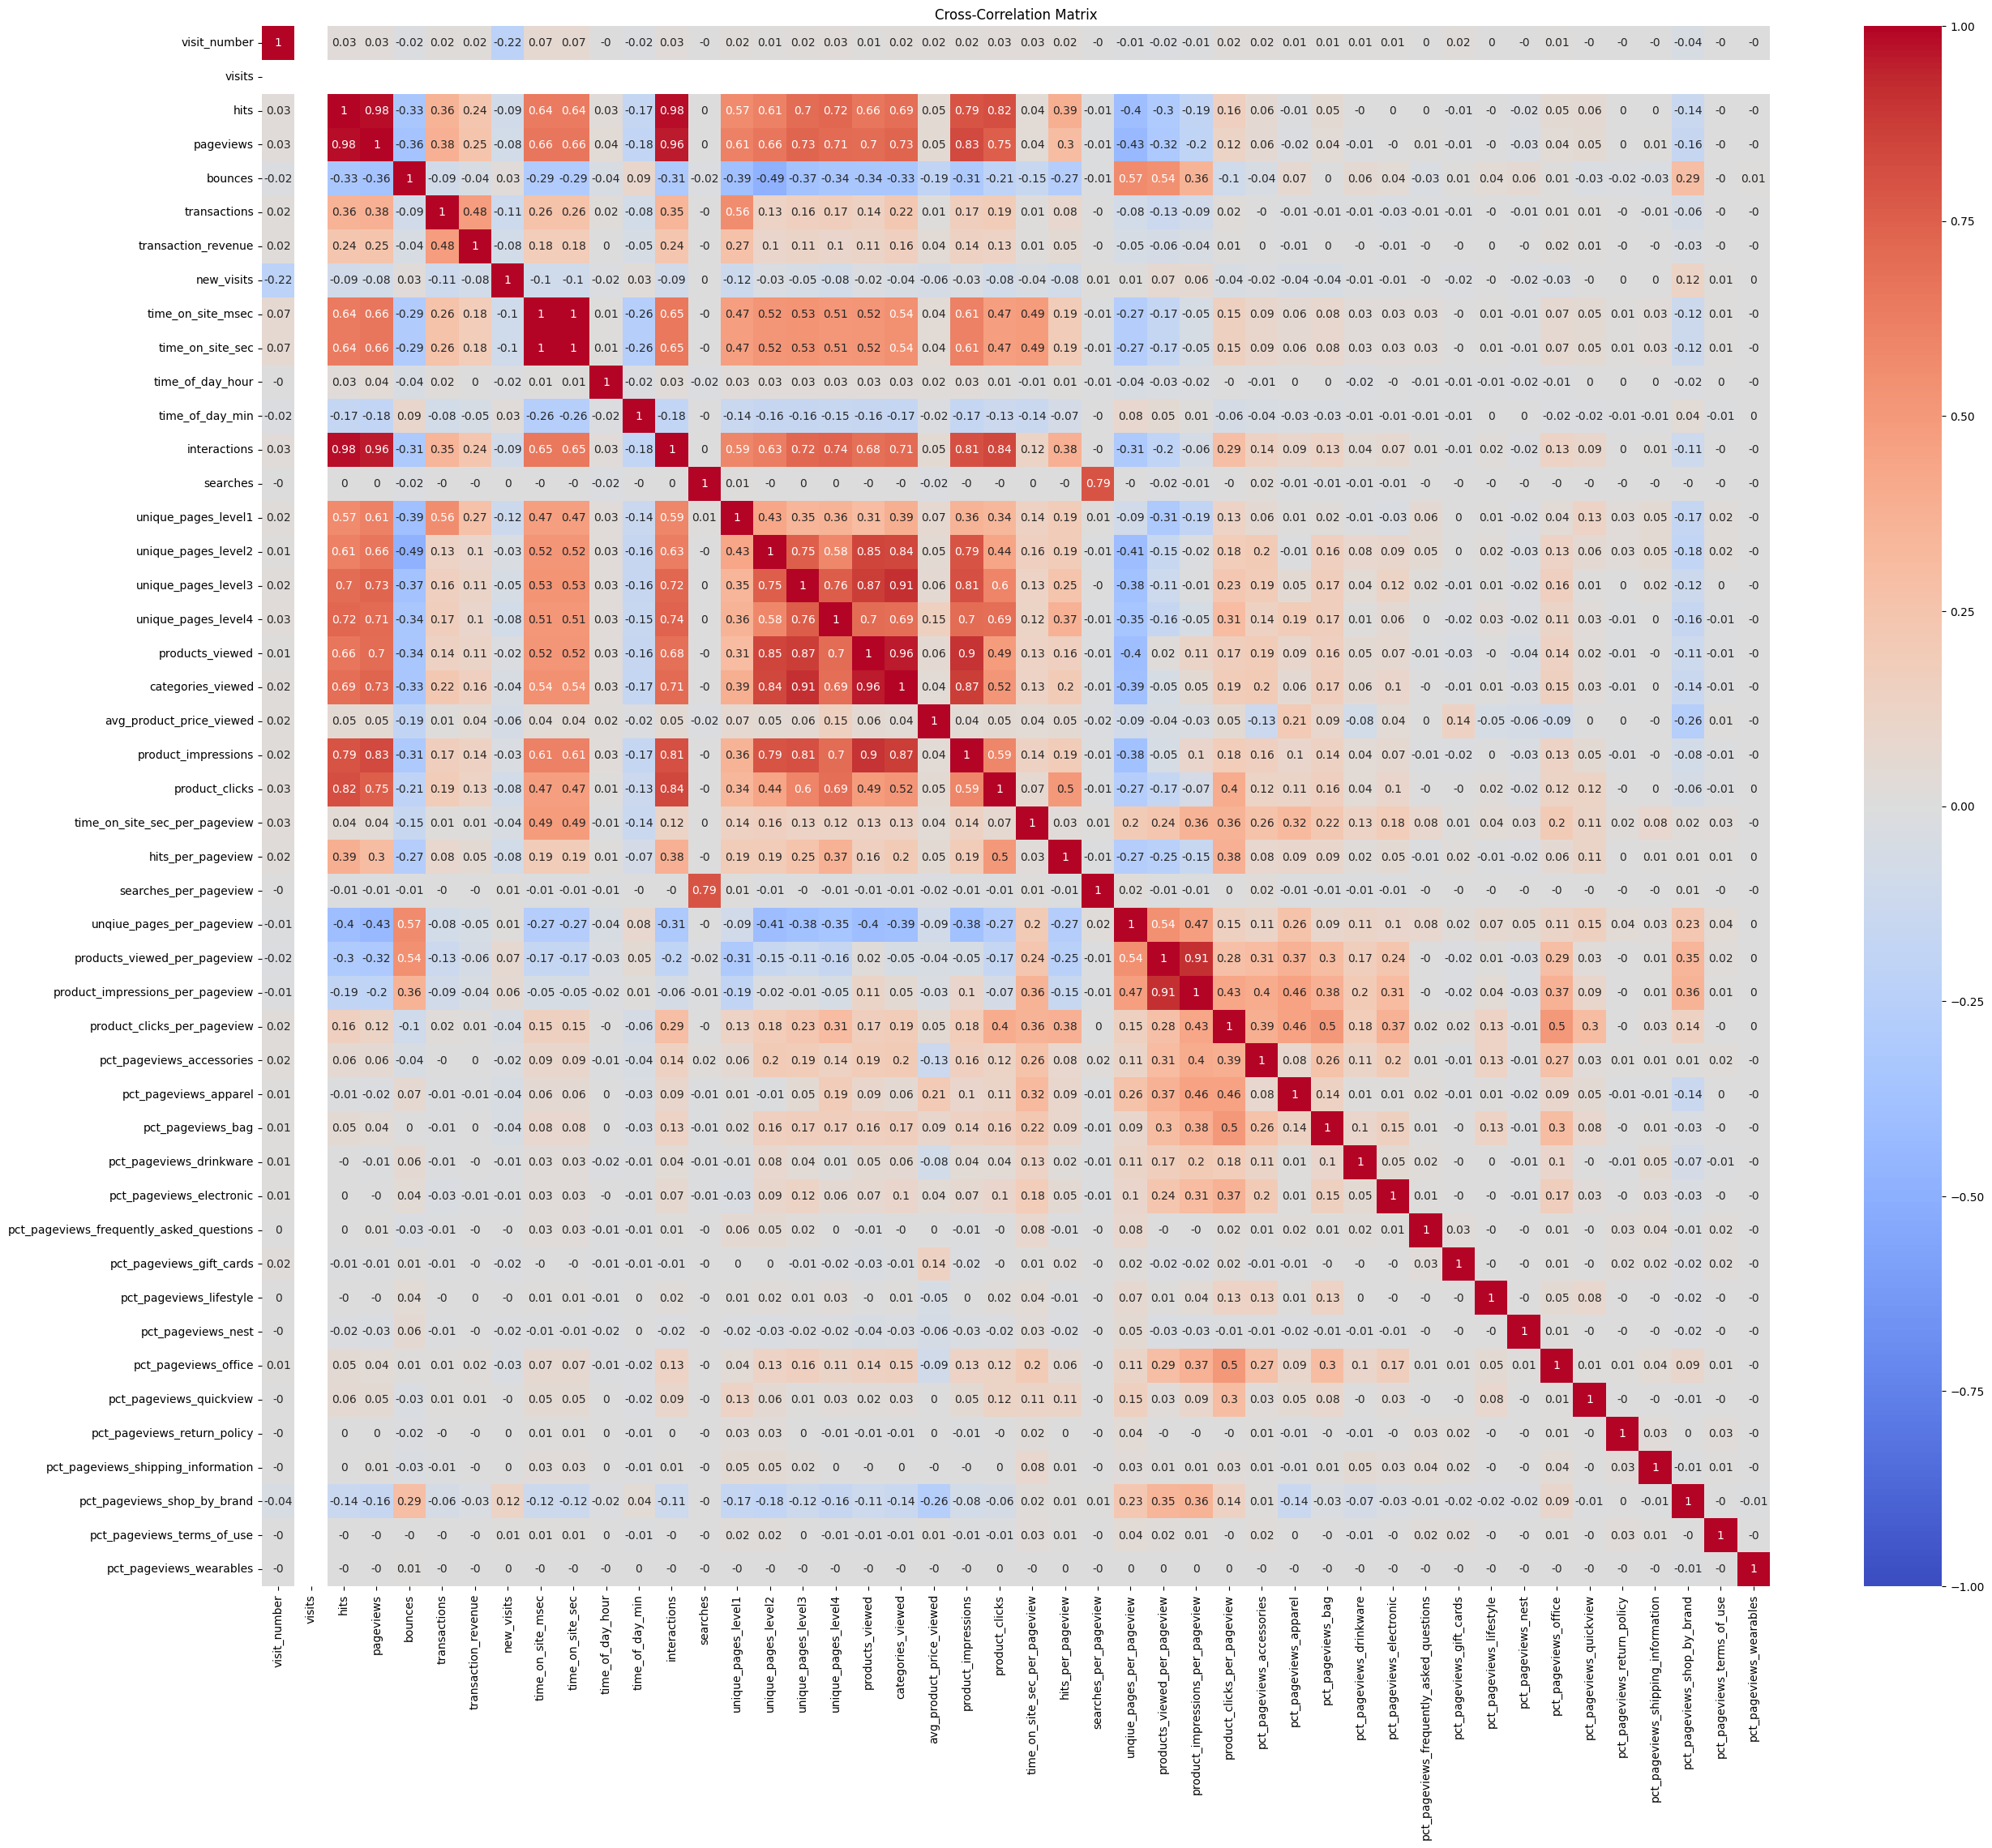

In [ ]:
# Calculate the correlation matrix
corr_matrix = df[FEATURE_SET].corr()
corr_matrix = corr_matrix.round(2)

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(30, 25))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Cross-Correlation Matrix')
plt.show()

##### [Takeaways]

##### **1. Adding rate and percentage metrics creates far more orthogonal (i.e. less-correlated) metrics.**

Base metrics -- such as hits, pageviews, unqiue pages -- are highly correlated. Dividing these metrics by pageviews, we're able to get far less correlated features, which will give us a more nuanced view of behavioral differences.

<br>

##### **2. We'll create two conceptually diverging segments.**

While building new features, I realized there are two conceptual types of feature sets forming.

1. Behavioral features

2. Content-based features

### Select new feature set

In [ ]:
SESSION_BEHAVIOR_FEATURE_SET = [
    'time_on_site_sec_per_pageview', # duration
    'pageviews', # engagement
    'searches_per_pageview', # search
    'products_viewed_per_pageview', # browsing
    'product_clicks_per_pageview', # clicks
    'avg_product_price_viewed' # price sensitivity
]

PAGE_PATH_FEATURE_SET = [
    # 'pageviews' # include ?
    'pct_pageviews_accessories',
    'pct_pageviews_apparel',
    'pct_pageviews_bag',
    'pct_pageviews_drinkware',
    'pct_pageviews_electronic',
    'pct_pageviews_frequently_asked_questions',
    'pct_pageviews_gift_cards',
    'pct_pageviews_lifestyle',
    'pct_pageviews_nest',
    'pct_pageviews_office',
    'pct_pageviews_quickview',
    'pct_pageviews_return_policy',
    'pct_pageviews_shipping_information',
    'pct_pageviews_shop_by_brand',
    'pct_pageviews_terms_of_use',
    'pct_pageviews_wearables',
]

### [Q] What's the correlation between features?

In [ ]:
# Calculate the correlation matrix
feature_corr_matrix = df[SESSION_BEHAVIOR_FEATURE_SET].corr()
feature_corr_matrix = feature_corr_matrix.round(2)

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(15, 4))
sns.heatmap(
    feature_corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Cross-Correlation Matrix')
plt.show()

### [Q] What's the distribution of each feature?

In [ ]:
# TO DO:

# Add code for histogram by feature


## Determine the best k-value

In the section below, we use the Elbow Method to identify an optimal k. We view the following metrics at different levels of k.
- SSD
- Silhouette Score
- Davies Bouldin Score
- Calinski Harabasz Score

### Build Elbow Method class

In [ ]:
class kmeansElbowMethod():

    def __init__(
        self,
        df,
        feature_set=FEATURE_SET,
        random_state=99,
        zscore_ceil=5,
        zscore_floor=-5
        ):
        self.df = df
        self.feature_set = feature_set
        self.random_state = random_state
        self.zscore_ceil = zscore_ceil
        self.zscore_floor = zscore_floor

    def get_elbow_metrics(
        self,
        k_range = range(2, 15, 1),
        sample_size = None
        ):

        # Initialize variables
        self.k_range = k_range
        self.sample_size = sample_size or len(df)
        self.metrics = []

        # Get sampled feature set
        # Decided to maintain the same sample rather than resampling
        X = df[self.feature_set].sample(self.sample_size)

        # Scale features
        scaler = StandardScaler()
        X_zscore = scaler.fit_transform(X)

        # Apply floor & ceiling to dataframe
        # TO DO: make optional
        # df_zscore = pd.DataFrame(X_zscore, columns=self.feature_set)
        X_zscore = np.minimum(X_zscore, 5)
        X_zscore = np.maximum(X_zscore, -5)

        # Apply k-means clustering for each k and calculate metrics
        for k in self.k_range:

            print('RUNNING: Clustering {} features for k={}.'.format(
                len(self.feature_set), k))
            model = KMeans(n_clusters=k, random_state=self.random_state)
            model.fit(X_zscore)
            labels = model.labels_

            # Append cluster performance metrics to output dataframe
            self.metrics.append({
                'k': k,
                'ssd': model.inertia_,
                'silhouette_scores': silhouette_score(X_zscore, labels),
                'db_scores': davies_bouldin_score(X_zscore, labels),
                'ch_scores': calinski_harabasz_score(X_zscore, labels),
                'n_features': len(self.feature_set)
            })

        # Return performance measures by k
        self.df_metrics = pd.DataFrame(self.metrics)
        return self.df_metrics

    def plot_elbow_metrics(self, df_metrics):
        # Plotting the metrics
        fig, axs = plt.subplots(2, 2, figsize=(15, 10))

        # Plot Sum of Squared Distances
        axs[0, 0].plot(self.df_metrics['k'], self.df_metrics['ssd'], 'bx-')
        axs[0, 0].set_xlabel('k')
        axs[0, 0].set_ylabel('Sum of Squared Distances')
        axs[0, 0].set_title('Elbow Method For Optimal k (SSD)')

        # Plot Silhouette Score
        axs[0, 1].plot(
            self.df_metrics['k'], self.df_metrics['silhouette_scores'], 'bx-')
        axs[0, 1].set_xlabel('k')
        axs[0, 1].set_ylabel('Silhouette Score')
        axs[0, 1].set_title('Silhouette Score For Different k')

        # Plot Davies-Bouldin Index
        axs[1, 0].plot(
            self.df_metrics['k'], self.df_metrics['db_scores'], 'bx-')
        axs[1, 0].set_xlabel('k')
        axs[1, 0].set_ylabel('Davies-Bouldin Index')
        axs[1, 0].set_title('Davies-Bouldin Index For Different k')

        # Plot Calinski-Harabasz Index
        axs[1, 1].plot(
            self.df_metrics['k'], self.df_metrics['ch_scores'], 'bx-')
        axs[1, 1].set_xlabel('k')
        axs[1, 1].set_ylabel('Calinski-Harabasz Index')
        axs[1, 1].set_title('Calinski-Harabasz Index For Different k')

        # Return the plot
        plt.tight_layout()
        return plt.show()



### Run Elbow Method class

This class outputs the different k-means goodness-of-fit metrics mentioned above. In a real analysis, we will create segments with different k-values.

In [ ]:
# Get elbow method measures and load to a dataframe
elbow = kmeansElbowMethod(df, feature_set=SESSION_BEHAVIOR_FEATURE_SET)
metrics = elbow.get_elbow_metrics(
    sample_size = 1_000,
    k_range = range(2, 15, 1)
    )
df_metrics = pd.DataFrame(metrics)
df_metrics

RUNNING: Clustering 6 features for k=2.


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


RUNNING: Clustering 6 features for k=3.


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


RUNNING: Clustering 6 features for k=4.
RUNNING: Clustering 6 features for k=5.


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


RUNNING: Clustering 6 features for k=6.
RUNNING: Clustering 6 features for k=7.


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


RUNNING: Clustering 6 features for k=8.
RUNNING: Clustering 6 features for k=9.


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


RUNNING: Clustering 6 features for k=10.
RUNNING: Clustering 6 features for k=11.


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


RUNNING: Clustering 6 features for k=12.
RUNNING: Clustering 6 features for k=13.


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


RUNNING: Clustering 6 features for k=14.


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,k,ssd,silhouette_scores,db_scores,ch_scores,n_features
0,2,2924.666461,0.330702,1.675535,268.787426,6
1,3,2369.766389,0.342419,1.338450,282.428136,6
2,4,1900.960691,0.292670,1.140349,316.357434,6
3,5,1466.954810,0.360919,0.949384,380.750242,6
4,6,1267.419772,0.370271,0.913671,383.498202,6
5,7,1116.579886,0.380153,0.947719,384.747078,6
6,8,991.915399,0.361081,1.000341,388.667434,6
7,9,909.085300,0.365963,0.968098,381.982950,6
8,10,854.254896,0.371548,0.981858,368.040941,6
9,11,787.782973,0.373730,0.936871,367.159570,6


### [Q] What should we use for our k-value?

##### [Answer]

Lorem ipsum ... my answer will go here.

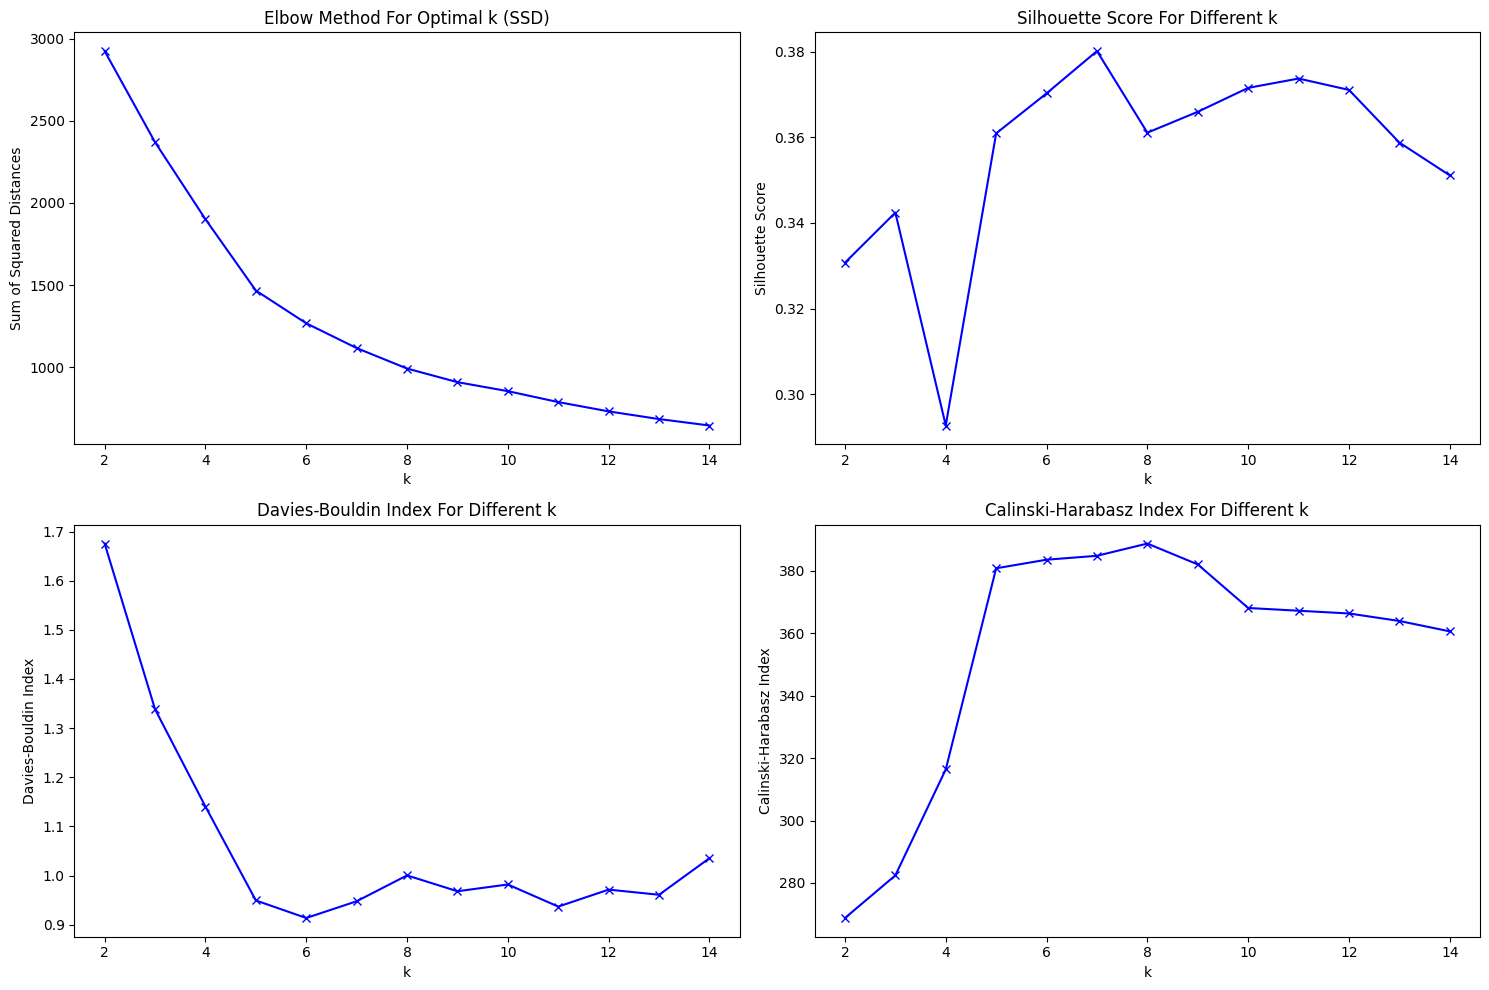

In [ ]:
elbow.plot_elbow_metrics(df_metrics)

## Run k-means model

We've created the class `kmeansCluster` to run the k-means model and analyze its outputs. Our first model will contain all of the features we've created. We include all features to get a general sense of what the outputs look like and whether they make sense. From there, we will **select the features based on what we want our segments to represent**.

In [ ]:
class kmeansCluster():

    def __init__(
        self,
        df,
        feature_set=FEATURE_SET,
        id_set=ID_SET,
        zscore_ceil=5,
        zscore_floor=-5
        ):
        self.df = df
        self.feature_set = feature_set
        self.id_set = id_set
        self.zscore_ceil = zscore_ceil
        self.zscore_floor = zscore_floor

    def _add_column_suffix(self, df, suffix):
        # Add z-score to each column
        rename_cols = {}
        for col in list(df):
            if 'label' not in col:
                rename_cols[col] = col + '_' + suffix

        df.rename(columns=rename_cols, inplace=True)
        return df

    def run(self, k):
        """Run k-means clustering and receive output with labels
        """
        print('RUNNING: Clustering {} obs with {} features for k={}.'.format(
            len(self.df), len(self.feature_set), k))

        # Get input dataframe
        X = self.df[self.feature_set]

        # Scale features
        # Going forward, we use _zscore to indicate data or columns
        # that have been scaled.
        print('RUNNING: Scaling features.')
        scaler = StandardScaler()
        X_zscore = scaler.fit_transform(X)
        X_zscore = np.minimum(X_zscore, self.zscore_ceil)
        X_zscore = np.maximum(X_zscore, self.zscore_floor)

        # Train k-means model
        # TO DO: Add kwargs to KMeans
        print('RUNNING: Training k-means model with {} features for k={}.'.format(
            len(self.feature_set), k))

        self.k = k
        self.model = KMeans(n_clusters=self.k, random_state=99)
        self.model.fit(X_zscore)
        self.labels = self.model.labels_

        # Get cluster similarity metrics
        self.metrics = {
            'k': self.k,
            'ssd': self.model.inertia_,
            'silhouette_scores': silhouette_score(X_zscore, self.labels),
            'db_scores': davies_bouldin_score(X_zscore, self.labels),
            'ch_scores': calinski_harabasz_score(X_zscore, self.labels),
            'n_features': len(self.feature_set)
        }

        # Append labels to input dataframe
        self.label_name = 'label_k' + str(self.k)
        df_labels = pd.DataFrame(self.labels, columns=[self.label_name])

        # Join labels to input dataframe
        if self.label_name in list(self.df):
            self.df = self.df.drop(columns=[self.label_name])
        self.df = df.join(df_labels, lsuffix='_old')

        # Load standardized input data to dataframe
        self.df_zscore = pd.DataFrame(X_zscore, columns=self.feature_set)

        # Drop the label column if it already exists
        if self.label_name in list(self.df_zscore):
            self.df_zscore = self.df_zscore.drop(columns=[self.label_name])

        # Join labels to standardized input dataframe
        self.df_zscore = self.df_zscore.join(df_labels, lsuffix='_old')

        # Join ids to standardized input dataframe
        self.df_zscore = self.df_zscore.join(df[self.id_set])
        self.df_zscore = self._add_column_suffix(
            self.df_zscore, suffix='zscore')

        return self.df

    def get_cluster_summary(self):
        """Get mean values by cluster label
        - absolute (ie original) values
        - z-scores
        - percentiles
        """
        print('RUNNING: Getting average values for {} features by cluster.'.format(
            len(self.feature_set)))
        # Get feature averages by cluster
        df_cluster_summary = self.df.groupby(self.label_name).mean().reset_index()
        drop_cols = [c for c in df_cluster_summary if 'old' in c]

        # Get column names for z-scores
        self.zscore_cols = [c + '_zscore' for c in self.feature_set]
        self.ptile_cols = [c + '_ptile' for c in self.feature_set]

        # Get the mean standardized metric by cluster
        print('RUNNING: Getting average z-scores for {} features by cluster.'.format(
            len(self.feature_set)))
        df_cluster_zscore = self.df_zscore.groupby(self.label_name).mean().reset_index()
        df_cluster_zscore = df_cluster_zscore[[self.label_name] + self.zscore_cols]

        # Add average percentile for each cluster
        print('RUNNING: Getting average percentiles for {} features by cluster.'.format(
            len(self.feature_set)))
        for col in self.zscore_cols:
            new_col = col.replace('zscore', 'ptile')
            df_cluster_zscore[new_col] = [norm.cdf(c) for c in df_cluster_zscore[col]]


        # Join absolute, z-scores, and %tiles into a single dataset
        df_cluster_summary = df_cluster_summary.join(
            df_cluster_zscore, on=self.label_name, rsuffix='_drop')
        drop_cols = [c for c in list(df_cluster_summary) if 'drop' in c]
        df_cluster_summary.drop(columns=drop_cols, inplace=True)
        self.df_cluster_summary = df_cluster_summary

        return self.df_cluster_summary

    def _get_cluster_attributes_by_zscore(self, row, col):
        desc = ''

        # Apply description for high values
        desc += 'XH ' + col.replace('_zscore', '') + ', ' if row[col] >= 3 else ''
        desc += 'VH ' + col.replace('_zscore', '') + ', ' if row[col] >= 2 else ''
        desc += 'H ' + col.replace('_zscore', '') + ', ' if row[col] >= 1 else ''

        # Apply description for low values
        desc += 'XL ' + col.replace('_zscore', '') + ', ' if row[col] <= -3 else ''
        desc += 'VL ' + col.replace('_zscore', '') + ', ' if row[col] <= -2 else ''
        desc += 'L ' + col.replace('_zscore', '') + ', ' if row[col] <= -1 else ''

        return desc

    def get_cluster_attributes(self):

        # Loop through each row in the cluster summary
        for i, row in self.df_cluster_summary.iterrows():
            cluster_desc = ''
            # Append cluster attributes based on the z-score
            for col in self.zscore_cols:
                cluster_desc += self._get_cluster_attributes_by_zscore(row, col)

            self.df_cluster_summary.loc[i, 'cluster_attributes'] = cluster_desc

        return self.df_cluster_summary


### K-means: Session Behavior

In [ ]:
# Specify k-value
k=9

# Run the initial model
kmeans = kmeansCluster(
    df,
    feature_set=SESSION_BEHAVIOR_FEATURE_SET
    )

# Get the input dataset with cluster labels
df = kmeans.run(k=k)
df.sample(10)

RUNNING: Clustering 36420 obs with 6 features for k=9.
RUNNING: Scaling features.
RUNNING: Training k-means model with 6 features for k=9.


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,date_id,visit_id,visit_start_time,visit_number,visits,hits,pageviews,bounces,transactions,transaction_revenue,...,pct_pageviews_nest,pct_pageviews_office,pct_pageviews_quickview,pct_pageviews_return_policy,pct_pageviews_shipping_information,pct_pageviews_shop_by_brand,pct_pageviews_terms_of_use,pct_pageviews_wearables,label_k9_old,label_k9
32373,20170124,1485289847,1485289847,1,1,5,3,0,0,0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,8,8
26644,20170116,1484612474,1484612474,1,1,30,24,0,0,0,...,0.0,0.000000,0.0,0.0,0.0,0.041667,0.0,0.0,7,7
22322,20170113,1484315511,1484315511,12,1,1,1,1,0,0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,5,5
7122,20170118,1484805527,1484805527,1,1,7,5,0,0,0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,2,2
9860,20170119,1484827573,1484827573,1,1,3,3,0,0,0,...,0.0,0.333333,0.0,0.0,0.0,0.333333,0.0,0.0,0,0
27578,20170123,1485226966,1485226966,1,1,2,2,0,0,0,...,0.0,0.000000,0.0,0.0,0.0,0.500000,0.0,0.0,5,5
7696,20170105,1483657808,1483657808,1,1,2,2,0,0,0,...,0.0,0.000000,0.0,0.0,0.0,0.500000,0.0,0.0,1,1
33854,20170103,1483436457,1483436457,1,1,2,2,0,0,0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0,0
27928,20170123,1485181398,1485181398,1,1,5,5,0,0,0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0,0
20350,20170120,1484905855,1484905855,1,1,5,5,0,0,0,...,0.0,0.000000,0.0,0.0,0.0,0.400000,0.0,0.0,1,1


### Get cluster summary

We have output the features in three formats:
- **True Values**. The average of actual value of the feature.

- **Value Z-scores**. The z-score of the average value, denoted with `_zscore`. This allows us to compare values across features.

- **Value Percentiles**. This is the average percentile for a given feature by cluster. Percentiles not only allow us to compare across features but also are easy to interpret.

In [ ]:
# Get feature averages by cluster label
# TO DO:
# - Add observation count/% to this output
# - Drop visitId, visitStartTime
df_cluster_summary = kmeans.get_cluster_summary()
df_cluster_summary

RUNNING: Getting average values for 6 features by cluster.
RUNNING: Getting average z-scores for 6 features by cluster.
RUNNING: Getting average percentiles for 6 features by cluster.


<ipython-input-24-1be2e0812a8c>:100: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_cluster_summary = self.df.groupby(self.label_name).mean().reset_index()
<ipython-input-24-1be2e0812a8c>:110: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_cluster_zscore = self.df_zscore.groupby(self.label_name).mean().reset_index()


,label_k9,visit_id,visit_start_time,visit_number,visits,hits,pageviews,bounces,transactions,transaction_revenue,...,searches_per_pageview_zscore,products_viewed_per_pageview_zscore,product_clicks_per_pageview_zscore,avg_product_price_viewed_zscore,time_on_site_sec_per_pageview_ptile,pageviews_ptile,searches_per_pageview_ptile,products_viewed_per_pageview_ptile,product_clicks_per_pageview_ptile,avg_product_price_viewed_ptile
0,0,1484710518.288201,1484710518.832446,2.253271,1.0,3.865824,3.657352,0.177977,0.002661,86878.465292,...,-0.008381,-0.449296,-0.243974,-0.759832,0.445709,0.393989,0.496656,0.326609,0.403625,0.223678
1,1,1484708559.767522,1484708561.055473,2.412765,1.0,5.685356,5.352818,0.007456,0.001342,153862.212944,...,-0.025825,-0.163066,-0.192829,0.435766,0.483523,0.469785,0.489699,0.435233,0.423546,0.668497
2,2,1484695047.441168,1484695048.207825,2.398356,1.0,4.855685,4.099234,0.233059,0.014176,3531933.654664,...,-0.028149,-0.182259,0.002515,2.373128,0.446430,0.413480,0.488772,0.427690,0.501003,0.991181
3,3,1484664783.31244,1484664784.12729,3.733848,1.0,55.976856,42.228544,0.0,0.322083,61546403.085824,...,-0.029575,-0.793257,0.401828,-0.012050,0.517627,0.999870,0.488203,0.213814,0.656095,0.495193
4,4,1484798370.389908,1484798442.788991,4.541284,1.0,1.614679,1.550459,0.770642,0.004587,221192.66055,...,-0.029575,3.999941,3.550218,0.074460,0.999265,0.305402,0.488203,0.999968,0.999808,0.529678
5,5,1484714665.845466,1484714666.288089,1.768199,1.0,1.300241,1.279147,0.862662,0.0,0.0,...,-0.029575,1.002553,-0.291373,-0.415618,0.374048,0.294657,0.488203,0.841962,0.385383,0.338845
6,6,1484731073.143757,1484731079.496327,4.513116,1.0,5.012592,4.519412,0.033578,0.001049,7334.732424,...,-0.024297,-0.202536,-0.092480,-0.005416,0.999046,0.432214,0.490308,0.419749,0.463158,0.497839
7,7,1484689698.30529,1484689699.827518,2.619302,1.0,20.624648,16.85256,0.0,0.090884,7023590.320765,...,-0.026744,-0.594248,0.205827,-0.036956,0.538852,0.891415,0.489332,0.276173,0.581537,0.485260
8,8,1484729291.206036,1484729295.076379,2.665052,1.0,9.160209,6.097243,0.006706,0.000373,13964.232489,...,-0.025827,-0.508350,1.235575,-0.259317,0.476885,0.503584,0.489698,0.305604,0.891692,0.397695


In [ ]:
# Get cluster attributes
# These give a high-to-low rating for each feature
df_cluster_summary = kmeans.get_cluster_attributes()

# Get average z-scores by cluster along with the cluster attributes
df_cluster_zscores = df_cluster_summary[[kmeans.label_name, 'cluster_attributes'] + kmeans.zscore_cols]
df_cluster_zscores = df_cluster_zscores.groupby(kmeans.label_name).mean()
df_cluster_zscores

<ipython-input-27-29688719a292>:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_cluster_zscores = df_cluster_zscores.groupby(kmeans.label_name).mean()


,time_on_site_sec_per_pageview_zscore,pageviews_zscore,searches_per_pageview_zscore,products_viewed_per_pageview_zscore,product_clicks_per_pageview_zscore,avg_product_price_viewed_zscore
label_k9,,,,,,
0,-0.136510,-0.268936,-0.008381,-0.449296,-0.243974,-0.759832
1,-0.041313,-0.075811,-0.025825,-0.163066,-0.192829,0.435766
2,-0.134685,-0.218603,-0.028149,-0.182259,0.002515,2.373128
3,0.044200,3.652508,-0.029575,-0.793257,0.401828,-0.012050
4,3.180352,-0.508926,-0.029575,3.999941,3.550218,0.074460
5,-0.321151,-0.539830,-0.029575,1.002553,-0.291373,-0.415618
6,3.104127,-0.170742,-0.024297,-0.202536,-0.092480,-0.005416
7,0.097542,1.234089,-0.026744,-0.594248,0.205827,-0.036956
8,-0.057974,0.008984,-0.025827,-0.508350,1.235575,-0.259317


### [Q] How correlated are our input features?

##### Answer

Most features are uncorrelated, with r < 0.1 in most cases, except:

- There's an inverse relationship (_r_ = -.43) between _pageviews_ and _products viewed per page_, meaning the more pages visitors view, the fewer products they tend to see.

- This suggests that there are **high and low-interaction visits**.
    - In high-interaction visits, visitors view many pages but few products on each page.
    - In low-interaction visits, visitors browse each page in more detail.

- There's a weaker, positive relationships between _clicks per page_ and _pageviews_ (_r_ = .25), as well as _clicks per page_ and _time per page_ (_r_ = .22).

    - Both of these relationships make sense -- the more "clicky" a session is the more engaged visitors are, both in terms of pageviews and time per page.

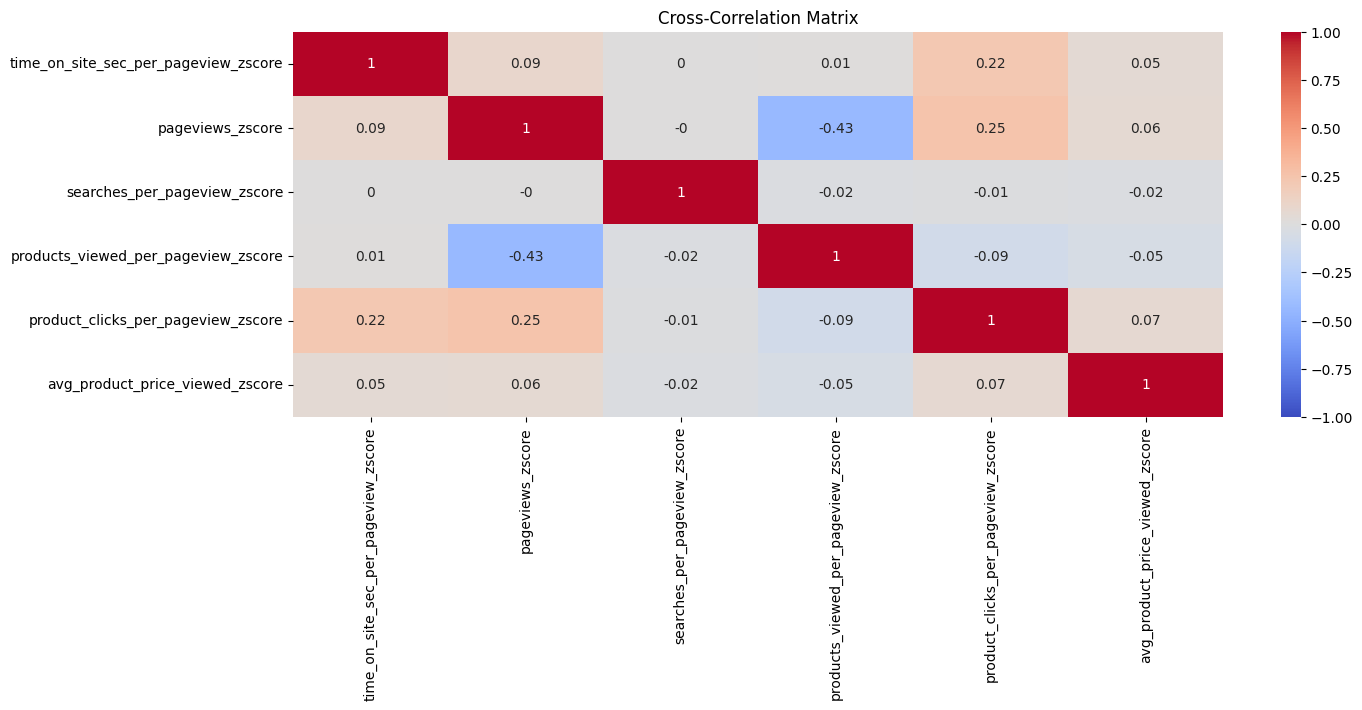

In [ ]:
# Calculate the correlation matrix
feature_corr_matrix = kmeans.df_zscore[kmeans.zscore_cols].corr()
feature_corr_matrix = feature_corr_matrix.round(2)

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(15, 4))
sns.heatmap(
    feature_corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Cross-Correlation Matrix')
plt.show()

### [Q] How do features differ across clusters?

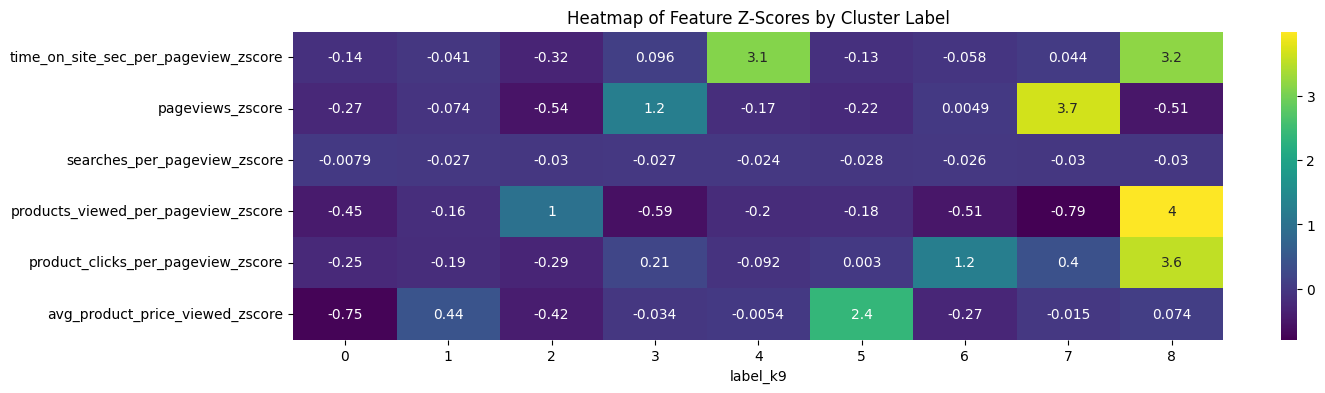

In [ ]:
# Creating the heatmap
plt.figure(figsize=(15, 4))
sns.heatmap(df_cluster_zscores.T, annot=True, cmap='viridis')
plt.title('Heatmap of Feature Z-Scores by Cluster Label')
plt.show()

### [Q] How do the clusters change over time?

##### Answer

While the distribution of clusters change slightly on a daily basis, the distribution remains fairly consistent over time.  

<Axes: xlabel='date_id'>

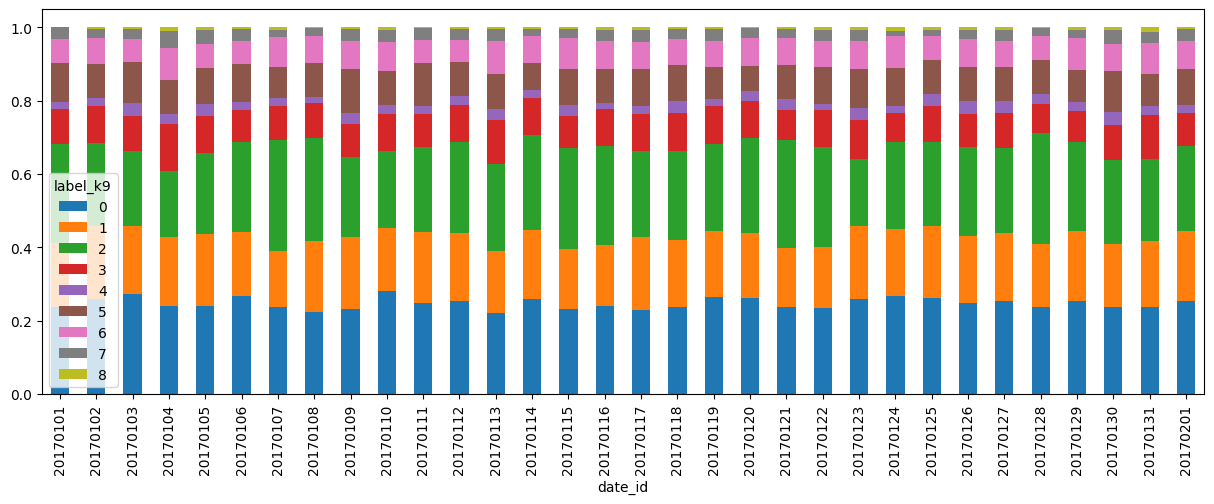

In [ ]:
# Get total daily visits (across all clusters)
visits_by_date = kmeans.df.groupby('date_id')['visits'].sum()

# Join to visit-level dataframe
kmeans.df = kmeans.df.merge(
    visits_by_date.rename('_total_visits'), on='date_id')

# Get % of daily visits
# Note that, at the visit level, this is a useless metric. We must use it
# to aggregate % of daily visits by cluster.
kmeans.df['pct_daily_visits'] = kmeans.df['visits'] / kmeans.df['_total_visits']

# Aggregate % of daily visits by cluster and date
plot_df = kmeans.df.pivot_table(
    index='date_id',
    columns=kmeans.label_name,
    values='pct_daily_visits',
    aggfunc='sum',
    fill_value=0
    )

# Plot the aggregated data
plot_df.plot(kind='bar', stacked=True, figsize=(15, 5))

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Total Visits')
plt.title('Total Visits by Cluster by Date')

# Display the plot
plt.show()


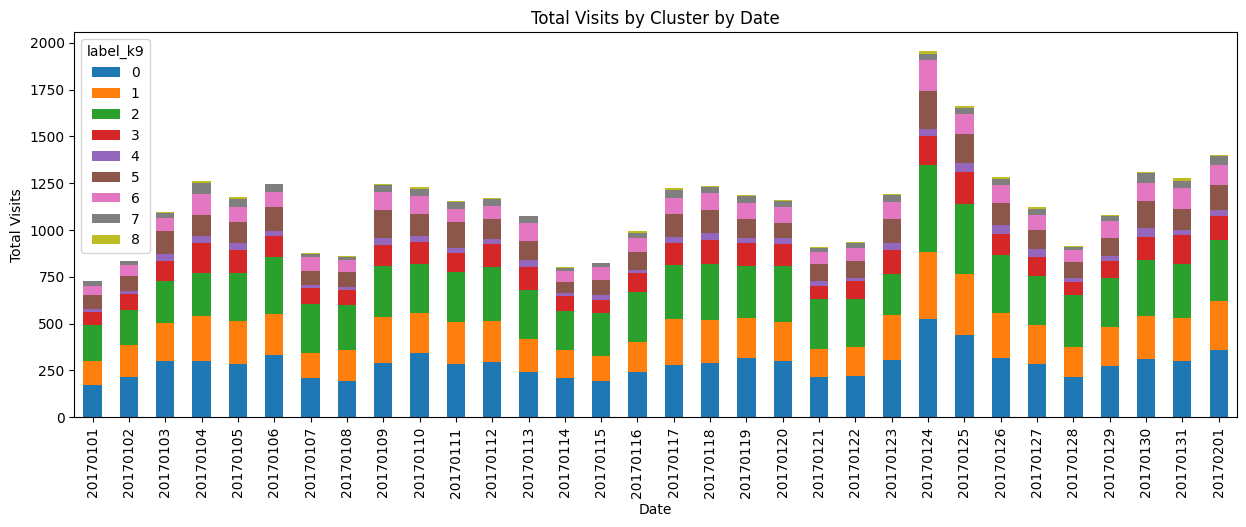

In [ ]:
# Plotting the stacked bar chart
plot_df = kmeans.df.pivot_table(
    index='date_id',
    columns='label_k9',
    values='visits',
    aggfunc='sum',
    fill_value=0
    )
plot_df.plot(kind='bar', stacked=True, figsize=(15, 5))

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Total Visits')
plt.title('Total Visits by Cluster by Date')

# Display the plot
plt.show()

### [Q] What's the average transaction value for each visit segment?

In [ ]:
# Get total visits, transactions, and revenue by cluster
plot_df = kmeans.df.groupby(kmeans.label_name).agg({
    'visits': 'sum',
    'transactions': 'sum',
    'transaction_revenue': 'sum',
}).reset_index()

# Get total visits, all time, all clusters
_total_visits = plot_df['visits'].sum()

# Get rate metrics
plot_df['pct_visits'] = plot_df['visits'] / _total_visits
plot_df['pct_visits_w_transaction'] = plot_df['transactions'] / plot_df['visits']
plot_df['revenue_per_transaction'] = plot_df['transaction_revenue'] / plot_df['transactions'] / 1e6

# TO DO: Add plot
plot_df

,label_k9,visits,transactions,transaction_revenue,pct_visits,pct_visits_w_transaction,revenue_per_transaction
0,0,6700,9,1031800000,0.183965,0.001343,114.644444
1,1,8736,0,0,0.239868,0.0,NaN
2,2,953,1,6990000,0.026167,0.001049,6.99
3,3,3526,49,12188390000,0.096815,0.013897,248.742653
4,4,1026,331,63185850000,0.028171,0.322612,190.893807
5,5,218,1,48220000,0.005986,0.004587,48.22
6,6,9043,25,794460000,0.248298,0.002765,31.7784
7,7,3528,326,25857360000,0.09687,0.092404,79.317055
8,8,2690,1,37480000,0.073861,0.000372,37.48


In [ ]:
# list(plot_df[kmeans.label_name])
# plot_df['visits']

[0, 1, 2, 3, 4, 5, 6, 7, 8]

IndexError: ignored

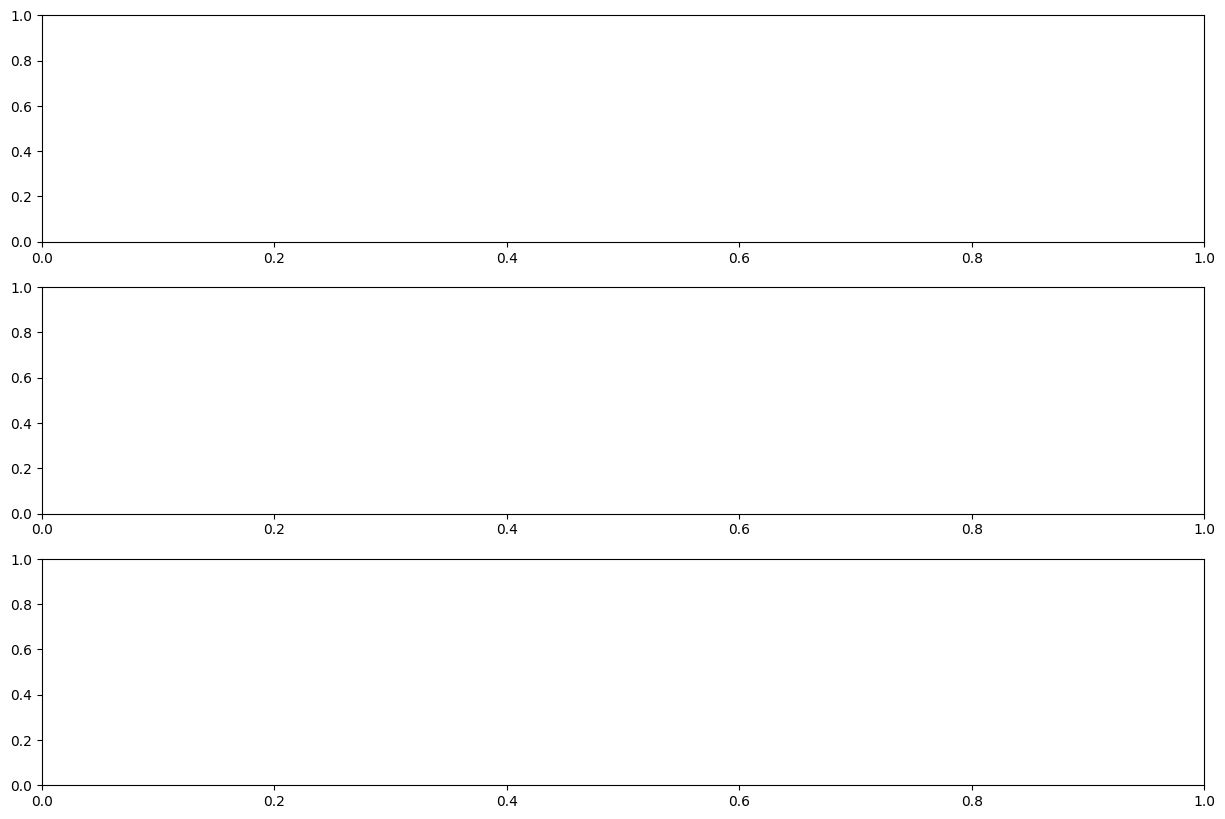

In [ ]:
# def plot_elbow_metrics(self, df_metrics):

# Plotting the metrics
fig, axs = plt.subplots(3, 1, figsize=(15, 10))

# Plot Sum of Squared Distances
axs[0, 0].plot(
    list(plot_df[kmeans.label_name]),
    list(plot_df['visits']),
    'bx-')
axs[0, 0].set_xlabel(kmeans.label_name)
axs[0, 0].set_ylabel('Visits')
axs[0, 0].set_title('Visits by Cluster')

# plot_df.plot(kind='bar', figsize=(15, 5))

# Return the plot
plt.tight_layout()
plt.show()


# # Adding labels and title
# plt.xlabel('Date')
# plt.ylabel('Total Visits')
# plt.title('Total Visits by Cluster by Date')

# # Display the plot
# plt.show()

## AI Generated Cluster Names

In the following section, we'll use ChatGPT to generate meaningful cluster names and descriptions. To do so, we'll pass it [feature definitions](https://docs.google.com/spreadsheets/d/1BwZ3dBRBLMWlB4WJy0FC-rsrJI--aoB78PRjthgWb4E/edit?usp=sharing) and a summary of feature metrics.

In [ ]:
kmeans.df.columns

Index(['date_id', 'visit_id', 'visit_start_time', 'visit_number', 'visits',
       'hits', 'pageviews', 'bounces', 'transactions', 'transaction_revenue',
       'new_visits', 'time_on_site_msec', 'time_on_site_sec',
       'time_of_day_hour', 'time_of_day_min', 'interactions', 'searches',
       'unique_pages_level1', 'unique_pages_level2', 'unique_pages_level3',
       'unique_pages_level4', 'pageviews_accessories', 'pageviews_apparel',
       'pageviews_bag', 'pageviews_bags', 'pageviews_drinkware',
       'pageviews_electronic', 'pageviews_frequently_asked_questions',
       'pageviews_gift_cards', 'pageviews_lifestyle', 'pageviews_nest',
       'pageviews_office', 'pageviews_quickview', 'pageviews_return_policy',
       'pageviews_shipping_information', 'pageviews_shop_by_brand',
       'pageviews_terms_of_use', 'pageviews_wearables', 'products_viewed',
       'categories_viewed', 'avg_product_price_viewed', 'product_impressions',
       'product_clicks', 'time_on_site_sec_per_page

In [ ]:
# Get session behavior metrics
cluster_metrics = SESSION_BEHAVIOR_FEATURE_SET

# Get revenue metrics
transaction_metrics = [
    'visit_number', 'hits', 'pageviews', 'bounces', 'transactions',
    'transaction_revenue', 'new_visits', 'time_on_site_sec',
    'time_of_day_hour', 'interactions', 'searches'
]

# Get other behavioral metrics
behavioral_metrics = [
    'products_viewed', 'categories_viewed',
    'avg_product_price_viewed', 'product_impressions',
    'product_clicks', 'time_on_site_sec_per_pageview', 'hits_per_pageview',
    'searches_per_pageview', 'unqiue_pages_per_pageview',
    'products_viewed_per_pageview', 'product_impressions_per_pageview',
    'product_clicks_per_pageview',
]

# Get pageview distribution metrics
pct_pageview_metrics = [
    'pct_pageviews_accessories', 'pct_pageviews_apparel',
    'pct_pageviews_bag', 'pct_pageviews_bags',
    'pct_pageviews_drinkware', 'pct_pageviews_electronic',
    'pct_pageviews_frequently_asked_questions', 'pct_pageviews_gift_cards',
    'pct_pageviews_lifestyle', 'pct_pageviews_nest', 'pct_pageviews_office',
    'pct_pageviews_quickview', 'pct_pageviews_return_policy',
    'pct_pageviews_shipping_information', 'pct_pageviews_shop_by_brand',
    'pct_pageviews_terms_of_use', 'pct_pageviews_wearables',
]


### Get metrics sumary to pass to ChatGPT

In [ ]:
# Get set of features for df.describe()
included_features = cluster_metrics + transaction_metrics + behavioral_metrics
df_cluster_agg = kmeans.df.groupby(kmeans.label_name)[included_features].describe()

# Create single-level header
new_columns = ['_'.join(col).strip() for col in df_cluster_agg.columns.values]
new_columns = [col.replace('%', '_ptile') for col in new_columns]
df_cluster_agg.columns = new_columns

# Get average % pageviews by category
df_pageviews_by_category = kmeans.df.groupby(kmeans.label_name)[
    pct_pageview_metrics].mean()

# Add pageviews by catgory to pageview distrib metrics
df_cluster_agg = df_cluster_agg.join(df_pageviews_by_category, on=kmeans.label_name)

df_cluster_agg


,time_on_site_sec_per_pageview_count,time_on_site_sec_per_pageview_mean,time_on_site_sec_per_pageview_std,time_on_site_sec_per_pageview_min,time_on_site_sec_per_pageview_25_ptile,time_on_site_sec_per_pageview_50_ptile,time_on_site_sec_per_pageview_75_ptile,time_on_site_sec_per_pageview_max,pageviews_count,pageviews_mean,...,pct_pageviews_gift_cards,pct_pageviews_lifestyle,pct_pageviews_nest,pct_pageviews_office,pct_pageviews_quickview,pct_pageviews_return_policy,pct_pageviews_shipping_information,pct_pageviews_shop_by_brand,pct_pageviews_terms_of_use,pct_pageviews_wearables
label_k9,,,,,,,,,,,,,,,,,,,,,
0,6700.0,28.324200,26.315122,0.000000,12.400033,20.004700,33.290018,170.822000,6700.0,5.377015,...,0.001912,0.000949,0.000449,0.023377,0.001669,0.000656,0.001446,0.093134,0.000392,0.000019
1,8736.0,5.034621,16.313645,0.000000,0.000000,0.000000,0.000000,192.226500,8736.0,1.28228,...,0.000038,0.000383,0.000343,0.031584,0.000000,0.000095,0.000172,0.524061,0.000000,0.000229
2,953.0,326.773954,211.982291,153.217500,201.160800,257.716250,375.692500,3524.055000,953.0,4.519412,...,0.001574,0.003754,0.012166,0.057202,0.003251,0.002160,0.004749,0.175485,0.002956,0.000000
3,3526.0,20.468473,33.074811,0.000000,2.664250,10.931167,21.857458,316.459333,3526.0,4.09274,...,0.015729,0.000388,0.000460,0.001436,0.004955,0.000873,0.001676,0.005359,0.000494,0.000071
4,1026.0,35.263165,23.059811,2.219952,20.613340,28.591924,42.993207,203.585146,1026.0,42.387914,...,0.000653,0.006101,0.000020,0.120042,0.016278,0.000486,0.001281,0.060846,0.000142,0.000026
5,218.0,471.177456,489.356469,21.121000,174.971750,299.084500,575.656250,3502.050000,218.0,1.550459,...,0.009174,0.069893,0.004587,1.434545,0.165028,0.009174,0.019004,1.150988,0.009174,0.000000
6,9043.0,20.326171,24.232746,0.000000,5.465250,13.859000,25.319604,165.272000,9043.0,3.665487,...,0.000849,0.009679,0.008974,0.066204,0.001704,0.001408,0.002514,0.174810,0.000769,0.000037
7,3528.0,39.611192,31.518132,2.731333,19.485173,28.217949,47.086739,220.435208,3528.0,16.953515,...,0.001378,0.003564,0.000177,0.092351,0.009790,0.000797,0.002115,0.080789,0.000426,0.000000
8,2690.0,26.905690,28.660902,0.000000,10.322325,17.838268,31.460250,207.629556,2690.0,6.110037,...,0.001578,0.002246,0.000177,0.108351,0.030020,0.000736,0.000879,0.295563,0.000062,0.000434


In [ ]:
# list(df_cluster_agg)

## Miscellaneous

Unused code and random stuff.

In [ ]:
# def plot_cluster_averages_by_metric(df, metrics, figsize=(15, 5)):

#     # Setting up the figure and axes
#     fig, axs = plt.subplots(
#         nrows=len(metrics),
#         ncols=1,
#         figsize=figsize,
#         sharex=True)

#     # Looping over each metric to create a bar chart
#     for i, metric in enumerate(metrics):
#         # Group by 'cluster_label' and calculate mean z-score
#         grouped_zscores = df.groupby(kmeans.label_name)[metric].mean()

#         # Plotting the bar chart
#         axs[i].bar(grouped_zscores.index, grouped_zscores.values)
#         axs[i].set_ylabel(metric)
#         axs[i].axhline(0, color='blue', linewidth=0.8)

#     # Set common labels
#     plt.xlabel('Cluster Label')
#     fig.suptitle('Z-Scores for Metrics Grouped by Cluster Label')

#     # Show the plot
#     plt.tight_layout(rect=[0, 0.03, 1, 0.95])
#     return plt.show()

In [ ]:
# plot_cluster_averages_by_metric(
#     kmeans.df_cluster_summary,
#     kmeans.zscore_cols,
#     figsize=(15, 20)
#     )